# Comparing simulation output for correlation estimation

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

In [297]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [298]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')
import memento
import memento.auxillary.simulate as simulate

In [299]:
data_path = '/home/ubuntu/Data/'
cell_type = 'CD4 T cells - ctrl'


In [300]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
%autoreload 2

### Calculate concordances

In [302]:
def concordance(x, y, mask, log=False):
    
    cond = mask

    if log:
        a = np.log(x[cond])
        b = np.log(y[cond])
    else:
        a = x[cond]
        b = y[cond]

    cmat = np.cov(a, b)
    return cond.sum(), 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [303]:
correlations = np.load(data_path + 'simulation/correlation/simulation_correlations.npz')['correlations']
meta = pd.read_csv(data_path + 'simulation/correlation/simulation_metadata.csv')

# OPTIONAL - filter genes for comparison
variances = correlations
gene_names = [f'pair_{i}' for i in range(correlations.shape[1])]

all_estimates = pd.concat([
    meta, 
    pd.DataFrame(correlations, columns=gene_names)],
    axis=1)

In [304]:
all_estimates.shape

(1920, 44855)

In [305]:
concordances = []
for name, group in all_estimates.groupby(['q', 'num_cell', 'trial', 'num_pairs']):
    methods = group['method']
    q, num_cell, trial, num_pair = name
    indices = np.all(np.isfinite(group[gene_names].values[:, :num_pair]), axis=0)
    ground_truth = group[gene_names].values[0, :num_pair]
    
    for idx, method in enumerate(methods):
    
        
        estimates = group[gene_names].values[idx, :num_pair]
        
        num_genes_used, c = concordance(estimates, ground_truth, indices)

        concordances.append((
            q,
            num_cell, 
            trial,
            method,
            num_genes_used,
            c
        ))
    
results = pd.DataFrame(concordances, columns=['q', 'num_cell', 'trial', 'method','num_valid_genes',  'concordance'])

In [306]:
def plot_curve(x, y, data, ax, marker, color, markersize, linestyle='-', label=''):
    
    agg_data = data.groupby(x)[y].agg(['mean', 'std'])
    x_data = agg_data.index
    y_data = agg_data['mean'].values
    y_err = agg_data['std']*3
    
    ax.plot(x_data, y_data, marker=marker, color=color, markersize=markersize, linestyle=linestyle, label=label)
    ax.fill_between(x_data, y_data-y_err, y_data+y_err, alpha=0.2, color=color)

In [308]:
results

,q,num_cell,trial,method,num_valid_genes,concordance
0,0.01,50,1,ground_truth,105,1.000000
1,0.01,50,1,naive,105,0.497835
2,0.01,50,1,poisson,105,0.547895
3,0.01,50,1,hypergeometric,105,0.549187
4,0.01,50,2,ground_truth,36,1.000000
...,...,...,...,...,...,...
1915,1.00,500,19,hypergeometric,42778,1.000000
1916,1.00,500,20,ground_truth,40755,1.000000
1917,1.00,500,20,naive,40755,1.000000
1918,1.00,500,20,poisson,40755,0.837492


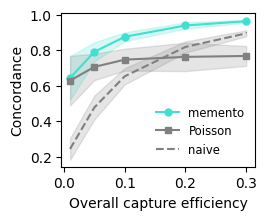

In [307]:
fig, ax = plt.subplots(figsize=(2.5,2))

num_cell_to_show = 500
q_limit=0.5

plot_curve('q', 'concordance', 
           data=results\
            .query(f'num_cell == {num_cell_to_show}')\
            .query('method == "hypergeometric"')\
            .query(f'q < {q_limit}') ,
           ax=ax, 
           color='turquoise',
           marker='o', 
           markersize=5,
           label='memento')

plot_curve('q', 'concordance', 
           data=results\
            .query(f'num_cell == {num_cell_to_show}')\
            .query('method == "poisson"')\
            .query(f'q < {q_limit}') ,
           ax=ax, 
           color='gray', 
           marker="s", 
           markersize=5,
           label='Poisson')

plot_curve('q', 'concordance', 
           data=results\
            .query(f'num_cell == {num_cell_to_show}')\
            .query('method == "naive"')\
            .query(f'q < {q_limit}') ,
           ax=ax, 
           color='gray', 
           marker=",", 
           linestyle='--',
           markersize=5,
           label='naive')

# plt.ylim(0.49, 1.01)


plt.xlabel('Overall capture efficiency')
plt.ylabel('Concordance')
plt.legend(frameon=False)